In [1]:
import datetime
import os
from itertools import cycle
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yaml
from tqdm import tqdm

from donors_choose_transformations import *
from pipeline.core import Pipeline
from pipeline.grid import Grid
from pipeline.splitter import Splitter
from pipeline.transformation import (Transformation, binarize, categorize,
                                     replace_missing_with_value, scale_by_max,
                                     to_datetime)

from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

tqdm.pandas()

%load_ext autoreload
%autoreload 2 
%matplotlib inline 

# 0/ pipeline configuration and instantiation
### load pipeline configuration from file and create `Pipeline` object

### to override the values of $k$ or the input dataset set in `config.yml`, update the variable in the cell below:

In [2]:
k_overrides = []
override_dataset = None

In [3]:
notebook_path = Path(os.path.abspath(''))
config_file   = 'config.yml'

with open(notebook_path/config_file, 'rb') as cnfg:
    config = yaml.safe_load(cnfg.read())

pipeline_name = config["pipeline"]["name"] if not override_dataset else override_dataset
input_path    = notebook_path/config["data"]["input_path"]
output_dir    = notebook_path/config["data"]["output_dir"]
target        = config["pipeline"]["target"]
splitter      = Splitter.from_config(config["pipeline"]["test_train"])

if not k_overrides:
    model_grid = Grid.from_config(config["models"])
else: 
    model_grid = Grid([{
        "KMeans-n_clusters-{}".format(k): KMeans(n_clusters=k) for k in k_overrides
    }])

In [4]:
pipeline = Pipeline(
    name            = pipeline_name,
    input_source    = input_path,
    target          = target,
    splitter        = splitter,
    model_grid      = model_grid,
    output_root_dir = output_dir,
    verbose         = True,
    positive_label  = 1,
    data_cleaning   = [
        to_datetime("date_posted"),
        to_datetime("datefullyfunded"),
        month_posted,
        funded_in_60_days],
    data_preprocessors = [
        replace_missing_with_value("students_reached", 0)
    ],
    feature_generators = [
        categorize("school_city"),
        categorize("school_state"),
        categorize("primary_focus_subject"),
        categorize("primary_focus_area"),
        categorize("resource_type"),
        categorize("poverty_level"),
        categorize("grade_level"),
        binarize("school_charter", true_value="t"),
        binarize("school_magnet", true_value="t"),
        scale_by_max("students_reached_clean"),
        scale_by_max("total_price_including_optional_support"),
        binarize("eligible_double_your_impact_match", true_value="t"),
    ])

# 1/ load data

In [5]:
pipeline = pipeline.load_data()

Loading data


# 2/ preprocess and generate features

In [6]:
pipeline = pipeline.clean_data()          \
                   .generate_test_train() \
                   .preprocess_data()     \
                   .generate_features()


Running transformations for cleaning
    Applying transformation (1/4): convert-date_posted-to-datetime 
    date_posted -> date_posted
    Applying transformation (2/4): convert-datefullyfunded-to-datetime 
    datefullyfunded -> datefullyfunded
    Applying transformation (3/4): month_posted 
    ['date_posted'] -> month_posted
    Applying transformation (4/4): funded_in_60_days 
    ['date_posted', 'datefullyfunded'] -> funded_in_60_days


100%|██████████| 124976/124976 [00:08<00:00, 15200.20it/s]


Running transformations for preprocessing
    Applying transformation (1/1): replace-missing-values-with-value(students_reached,0) 
    ['students_reached'] -> students_reached_clean


Running transformations for feature generation
    Applying transformation (1/12): categorize-school_city 
    ['school_city'] -> school_city_categorical
    Applying transformation (2/12): categorize-school_state 
    ['school_state'] -> school_state_categorical
    Applying transformation (3/12): categorize-primary_focus_subject 
    ['primary_focus_subject'] -> primary_focus_subject_categorical
    Applying transformation (4/12): categorize-primary_focus_area 
    ['primary_focus_area'] -> primary_focus_area_categorical
    Applying transformation (5/12): categorize-resource_type 
    ['resource_type'] -> resource_type_categorical
    Applying transformation (6/12): categorize-poverty_level 
    ['poverty_level'] -> poverty_level_categorical
    Applying transformation (7/12): categorize-grade_level 

# 3/ train $k$-means models

In [7]:
pipeline = pipeline.run_model_grid()

Training models.
Features: ['school_city_categorical', 'grade_level_categorical', 'total_price_including_optional_support_scaled', 'resource_type_categorical', 'primary_focus_subject_categorical', 'school_state_categorical', 'primary_focus_area_categorical', 'school_charter_binary', 'eligible_double_your_impact_match_binary', 'school_magnet_binary', 'students_reached_clean_scaled', 'poverty_level_categorical']
Fitting: funded_in_60_days
    Training model KMeans-n_clusters5
        Training on training set "split 0" (1/3)
        Training on training set "split 1" (2/3)
        Training on training set "split 2" (3/3)
    Training model KMeans-n_clusters10
        Training on training set "split 0" (1/3)
        Training on training set "split 1" (2/3)
        Training on training set "split 2" (3/3)
    Training model KMeans-n_clusters50
        Training on training set "split 0" (1/3)
        Training on training set "split 1" (2/3)
        Training on training set "split 2" (3/3)
  

### use elbow method to determine optimal value of $k$

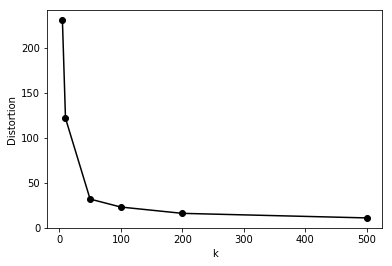

In [37]:
k_values = []
distortions = []
X = pipeline.test_sets[-1][pipeline.features]
X_ = pipeline.train_sets[-1][pipeline.features]

for (description, models) in pipeline.trained_models.items():
    model = models[-1]
    k_values.append(model.n_clusters)
    distortions.append(sum(np.min(cdist(X, model.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])

plt.plot(k_values, distortions, 'ko-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.show()


### from the graph above, the optimal value of $k$ is 50. 

# 4/ per-cluster statistics

### choose the clustering model with 50 clusters trained on the largest dataset, and choose a cluster label to summarize

In [49]:
model = pipeline.trained_models['KMeans-n_clusters50'][-1]

cluster_labels = [15]
clusters = pd.DataFrame({'data_index': X_.index.values, 'label': model.labels_})

X_.loc[clusters[clusters.label.isin(cluster_labels)].data_index].describe()

,school_city_categorical,grade_level_categorical,total_price_including_optional_support_scaled,resource_type_categorical,primary_focus_subject_categorical,school_state_categorical,primary_focus_area_categorical,school_charter_binary,eligible_double_your_impact_match_binary,school_magnet_binary,students_reached_clean_scaled,poverty_level_categorical
count,1317.000000,1317.000000,1317.000000,1317.000000,1317.000000,1317.000000,1317.000000,1317.000000,1317.000000,1317.000000,1317.000000,1317.000000
mean,3669.630220,1.594533,0.006409,1.828398,14.345482,20.481397,3.231587,0.151860,0.161731,0.076689,0.006976,1.135156
std,16.880073,1.249766,0.006824,1.138981,6.145513,15.103261,1.330712,0.359022,0.368344,0.266199,0.010441,0.858509
min,3622.000000,0.000000,0.001061,-1.000000,-1.000000,2.000000,-1.000000,0.000000,0.000000,0.000000,0.000329,0.000000
25%,3657.000000,0.000000,0.003364,1.000000,13.000000,4.000000,3.000000,0.000000,0.000000,0.000000,0.001976,1.000000
50%,3677.000000,2.000000,0.005050,2.000000,15.000000,23.000000,3.000000,0.000000,0.000000,0.000000,0.002553,1.000000
75%,3682.000000,3.000000,0.007598,3.000000,17.000000,27.000000,4.000000,0.000000,0.000000,0.000000,0.007906,1.000000
max,3699.000000,3.000000,0.118814,4.000000,26.000000,49.000000,6.000000,1.000000,1.000000,1.000000,0.082270,3.000000


# 5/ user interaction

## A/ merge several clusters into 1: 
add cluster index to `cluster_labels` in the cell above

## B/ recluster with a new $k$:
override the values of $k$ in the variable `k_overrides` in the top of the notebook

## C/ split a specific cluster into many
use the above cell to generate a dataframe with the specific cluster and create a new `Pipeline` object with the `input_source` set to the dataframe